# Serial‑Dilution Consumer–Resource Model

This notebook implements and explores a minimal consumer–resource model of a
microbial community in *serial‑dilution* (batch) culture.

We track two microbial species, $A$ and $B$, and two substitutable nutrients, $c_1$ and $c_2$. Within a batch, time $t$ is measured from 0 to $t_f$, the dynamics obey Monod uptake kinetics with half-saturation constant $K$:


\begin{aligned}
\frac{d c_1}{d t} &= -A\,j_{A,1}(c_1)-B\,j_{B,1}(c_1), \\[4pt]
\frac{d c_2}{d t} &= -A\,j_{A,2}(c_2)-B\,j_{B,2}(c_2), \\[4pt]
\frac{d A}{d t} &= A\,[j_{A,1}(c_1)+j_{A,2}(c_2)], \\[4pt]
\frac{d B}{d t} &= B\,[j_{B,1}(c_1)+j_{B,2}(c_2)],
\end{aligned}


with $j_{A,i}(c_i)=\alpha_{A,i}\,\frac{c_i}{c_i+K}$ the species $A$ consumption of nutrient $i$, and $\alpha_{A,i}$ the maximal uptake rate at saturating nutrient levels, similarly for species $B$.

Assuming the time of the end of the batch is late enough, at $t=t_f$ the nutrients are almost entirely depleted; biomass is **diluted** by a factor $D$ and fresh nutrients $(c_1^{\mathrm{in}},c_2^{\mathrm{in}})$ are added. Repeating batches eventually yields a periodic steady state where all surviving species grow by the same fold‑change each cycle.

This notebook allows you to:

* Simulate a single batch
* Iterate batches until convergence
* Explore parameters interactively

---

In [2]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120  # higher‑resolution plots

# Optional interactive widgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("ipywidgets not installed – interactive sliders disabled.")

In [3]:
# ---------------------------------------------------------------------
def batch_odes(t, y, params):
    '''
    RHS for one batch.
    y = [c1, c2, A, B]
    params: dict with uptake rates & K
    '''
    c1, c2, A, B = y
    αA1, αA2 = params['αA1'], params['αA2']
    αB1, αB2 = params['αB1'], params['αB2']
    K = params['K']

    jA1 = αA1 * c1 / (c1 + K)
    jA2 = αA2 * c2 / (c2 + K)
    jB1 = αB1 * c1 / (c1 + K)
    jB2 = αB2 * c2 / (c2 + K)

    dc1_dt = -(A * jA1 + B * jB1)
    dc2_dt = -(A * jA2 + B * jB2)
    dA_dt = A * (jA1 + jA2)
    dB_dt = B * (jB1 + jB2)
    return [dc1_dt, dc2_dt, dA_dt, dB_dt]


def simulate_one_batch(y0, params, t_final=20, rtol=1e-8, atol=1e-10):
    '''
    Integrate ODEs for a single batch up to t_final.
    '''
    sol = solve_ivp(batch_odes, (0, t_final), y0, args=(params,),
                    dense_output=False, max_step=0.01, rtol=rtol, atol=atol)
    return sol


def serial_dilution(initial_state, params, n_batches=20,
                    D=0.1, nut_in=(10.0, 10.0), t_final=20):
    '''
    Iterate batches with dilution factor D and fresh nutrient bolus nut_in.
    Returns array with biomass at end of each batch *after dilution*.
    '''
    state = list(initial_state)
    history = []
    for _ in range(n_batches):
        sol = simulate_one_batch(state, params, t_final=t_final)
        c1, c2, A, B = sol.y[:, -1]
        history.append([A, B])
        state = [nut_in[0], nut_in[1], D * A, D * B]
    return np.array(history)

## Quick start: simulation with default parameter set

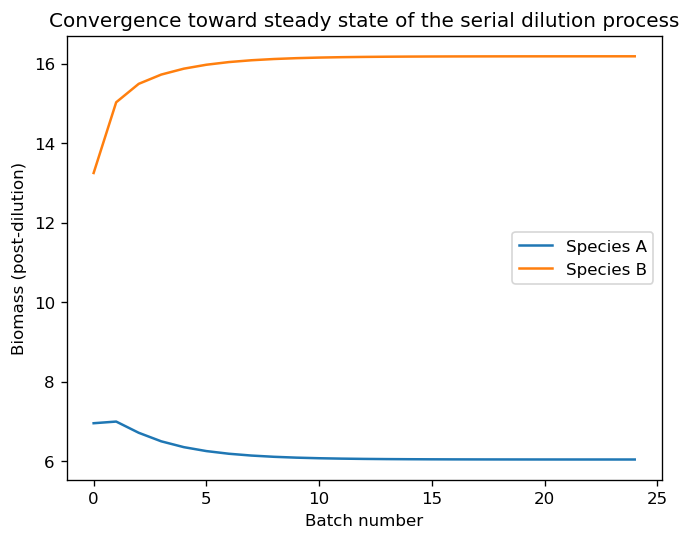

In [4]:
# Parameter dictionary
params = dict(
    αA1=1.0, αA2=0.2,   # Species A
    αB1=0.3, αB2=1.2,   # Species B
    K=0.5
)

# Initial state: [c1, c2, A, B]
y0 = [10.0, 10.0, 0.1, 0.1]

hist = serial_dilution(y0, params, n_batches=25, D=0.1, nut_in=(10, 10))

fig, ax = plt.subplots()
ax.plot(hist[:, 0], label='Species A')
ax.plot(hist[:, 1], label='Species B')
ax.set_xlabel('Batch number')
ax.set_ylabel('Biomass (post‑dilution)')
ax.set_title('Convergence toward steady state of the serial dilution process')
ax.legend();

## Explore parameters interactively (requires `ipywidgets`)

In [5]:
if HAS_WIDGETS:
    def run_and_plot(αA1=1.0, αA2=0.2, αB1=0.3, αB2=1.2):
        params = dict(αA1=αA1, αA2=αA2,
                      αB1=αB1, αB2=αB2, K=0.5)
        y0 = [10, 10, 0.1, 0.1]
        hist = serial_dilution(y0, params, n_batches=50,
                               D=0.1, nut_in=(10, 10))
        fig, ax = plt.subplots()
        ax.plot(hist[:, 0], label='A')
        ax.plot(hist[:, 1], label='B')
        ax.set_xlabel('Batch')
        ax.set_ylabel('Biomass (post‑dilution)')
        ax.set_ylim(0, hist.max()*1.1)
        ax.set_title('Parameter exploration')
        ax.legend()
        plt.show()

    interact(run_and_plot,
             αA1=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0),
             αA2=FloatSlider(min=0.0, max=2.0, step=0.1, value=0.2),
             αB1=FloatSlider(min=0.0, max=2.0, step=0.1, value=0.3),
             αB2=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.2));

interactive(children=(FloatSlider(value=1.0, description='αA1', max=2.0, min=0.1), FloatSlider(value=0.2, desc…